In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import optuna
import pickle

# Загружаем ваш датасет
df = pd.read_csv("C:\DS\SF\ML\Data/bank_fin.csv", sep=';')

df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [9]:
# Очистка колоноки balance “2 343,00 $” → 2343.00
def clean_balance(x):
    if isinstance(x, str):
        x = x.replace(" ", "")
        x = x.replace("$", "")
        x = x.replace(",", ".")
    return float(x)

df["balance"] = df["balance"].apply(clean_balance)

# Перевод deposit yes/no → 1/0
df["deposit"] = df["deposit"].map({"yes": 1, "no": 0})

# Цель и признаки
y = df["deposit"]
X = df.drop("deposit", axis=1)

# Числовые и категориальные признаки
numeric_features = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]
categorical_features = [col for col in X.columns if col not in numeric_features]

df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,1


In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


In [11]:
def objective(trial):

    n_estimators = trial.suggest_int("n_estimators", 100, 200)
    max_depth = trial.suggest_int("max_depth", 10, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    score = cross_val_score(
        pipe, X, y,
        cv=5,
        scoring="accuracy"
    ).mean()

    return score


In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print("Best parameters:", study.best_params)


[I 2025-11-22 12:25:03,916] A new study created in memory with name: no-name-000b33bd-bc6e-4c12-bb73-0e095e2e7ff0
[I 2025-11-22 12:25:09,348] Trial 0 finished with value: 0.7857146067379661 and parameters: {'n_estimators': 167, 'max_depth': 25, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7857146067379661.
[I 2025-11-22 12:25:14,061] Trial 1 finished with value: 0.7894768036314199 and parameters: {'n_estimators': 143, 'max_depth': 27, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.7894768036314199.
[I 2025-11-22 12:25:21,008] Trial 2 finished with value: 0.7945826451388186 and parameters: {'n_estimators': 198, 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7945826451388186.
[I 2025-11-22 12:25:25,848] Trial 3 finished with value: 0.785266618192091 and parameters: {'n_estimators': 151, 'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.7945826451388186.
[I 2025-11-22 12:25:32,600] Trial 4 finished with value: 0.7950303126610134

Best parameters: {'n_estimators': 128, 'max_depth': 30, 'min_samples_leaf': 2}


In [13]:
best_params = study.best_params

final_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_leaf=best_params["min_samples_leaf"],
        random_state=42
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Accuracy на тестовой выборке:", round(acc, 2))


Accuracy на тестовой выборке: 0.83


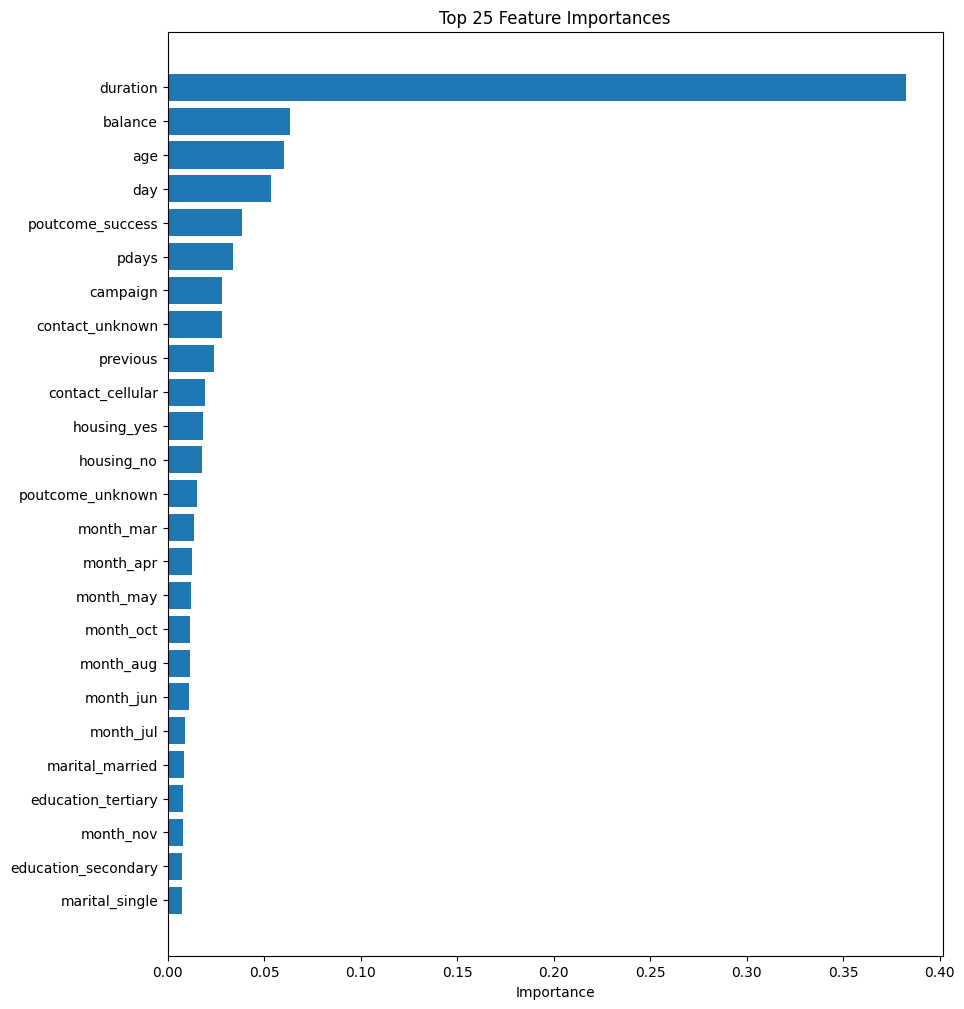

In [14]:
# Извлекаем RandomForest
rf = final_model.named_steps["model"]
ohe = final_model.named_steps["preprocess"].named_transformers_["cat"]

# Финальные имена признаков
num_features = numeric_features
cat_features = list(ohe.get_feature_names_out(categorical_features))
all_features = num_features + cat_features

# Важности
importances = rf.feature_importances_

fi_df = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 12))
plt.barh(fi_df["feature"].head(25), fi_df["importance"].head(25))
plt.gca().invert_yaxis()
plt.title("Top 25 Feature Importances")
plt.xlabel("Importance")
plt.show()
